In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv
/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv


### Import Packages

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [3]:
df = pd.read_csv('/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv')
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [5]:
df.shape

(43800, 9)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pollution,43800.0,94.013516,92.252276,0.00,24.00,68.00,132.25,994.0
dew,43800.0,1.828516,14.429326,-40.00,-10.00,2.00,15.00,28.0
temp,43800.0,12.459041,12.193384,-19.00,2.00,14.00,23.00,42.0
press,43800.0,1016.447306,10.271411,991.00,1008.00,1016.00,1025.00,1046.0
wnd_spd,43800.0,23.894307,50.022729,0.45,1.79,5.37,21.91,585.6
snow,43800.0,0.052763,0.760582,0.00,0.00,0.00,0.00,27.0
rain,43800.0,0.195023,1.416247,0.00,0.00,0.00,0.00,36.0


In [7]:
df_test = pd.read_csv('/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv')
df_test.head()

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dew        346 non-null    int64  
 1   temp       346 non-null    int64  
 2   press      346 non-null    int64  
 3   wnd_dir    346 non-null    object 
 4   wnd_spd    346 non-null    float64
 5   snow       346 non-null    int64  
 6   rain       346 non-null    int64  
 7   pollution  346 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 21.8+ KB


In [10]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
dew,346.0,-13.878613,4.029925,-27.00,-16.00,-14.000,-11.0000,-6.00
temp,346.0,-0.653179,4.548732,-9.00,-4.00,-1.500,2.0000,11.00
press,346.0,1026.083815,5.996272,1011.00,1022.00,1027.000,1031.0000,1035.00
wnd_spd,346.0,62.473815,107.500012,0.45,2.67,7.825,58.7825,441.18
snow,346.0,0.000000,0.000000,0.00,0.00,0.000,0.0000,0.00
rain,346.0,0.000000,0.000000,0.00,0.00,0.000,0.0000,0.00
pollution,346.0,96.398844,98.298524,0.00,14.00,63.500,157.5000,444.00


### Data Visualisation and Feature Scaling

In [11]:
df_train_scaled = df.copy()
df_test_scaled = df_test.copy()

# Define the mapping dictionary
mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

# Replace the string values with numerical values
df_train_scaled['wnd_dir'] = df_train_scaled['wnd_dir'].map(mapping)
df_test_scaled['wnd_dir'] = df_test_scaled['wnd_dir'].map(mapping)

df_train_scaled['date'] = pd.to_datetime(df_train_scaled['date'])
# Resetting the index
df_train_scaled.set_index('date', inplace=True)
df_train_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,1,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,1,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,1,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,1,6.25,2,0


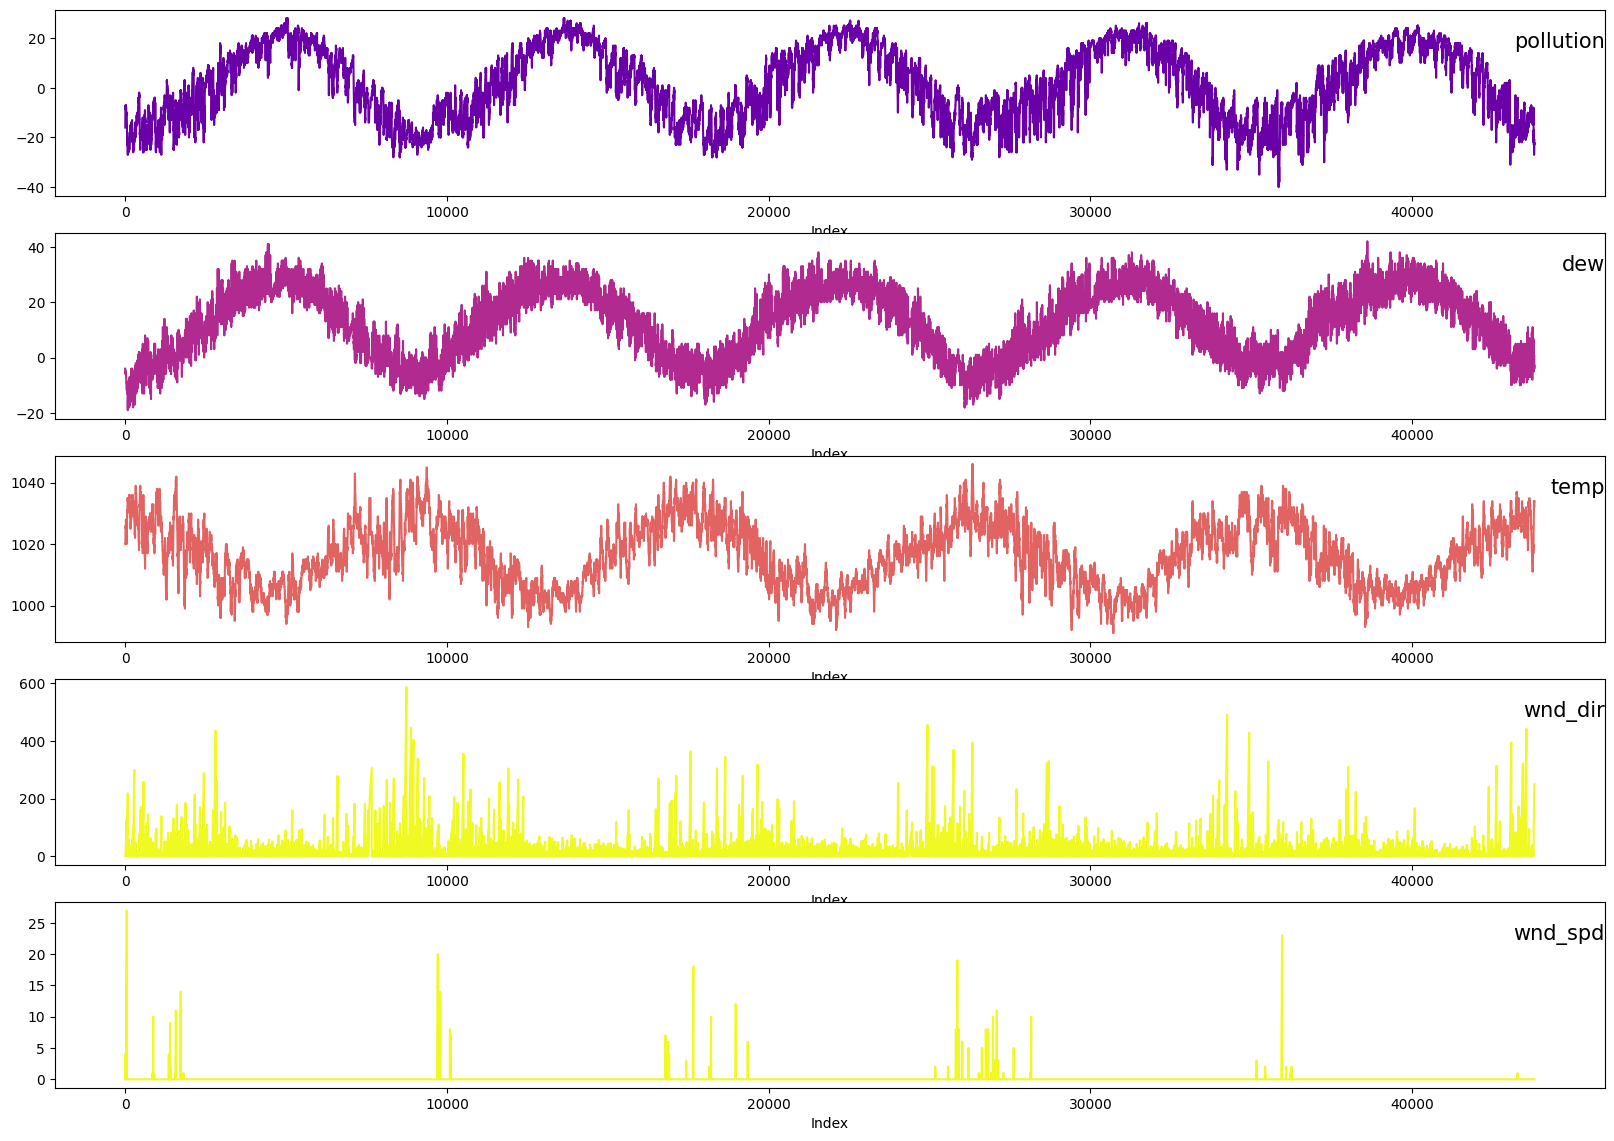

In [13]:
values = df_train_scaled.values

# specify columns to plot
groups = [1, 2, 3, 5, 6]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], color=cm.plasma(group/len(groups)))
    plt.xlabel('Index')
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

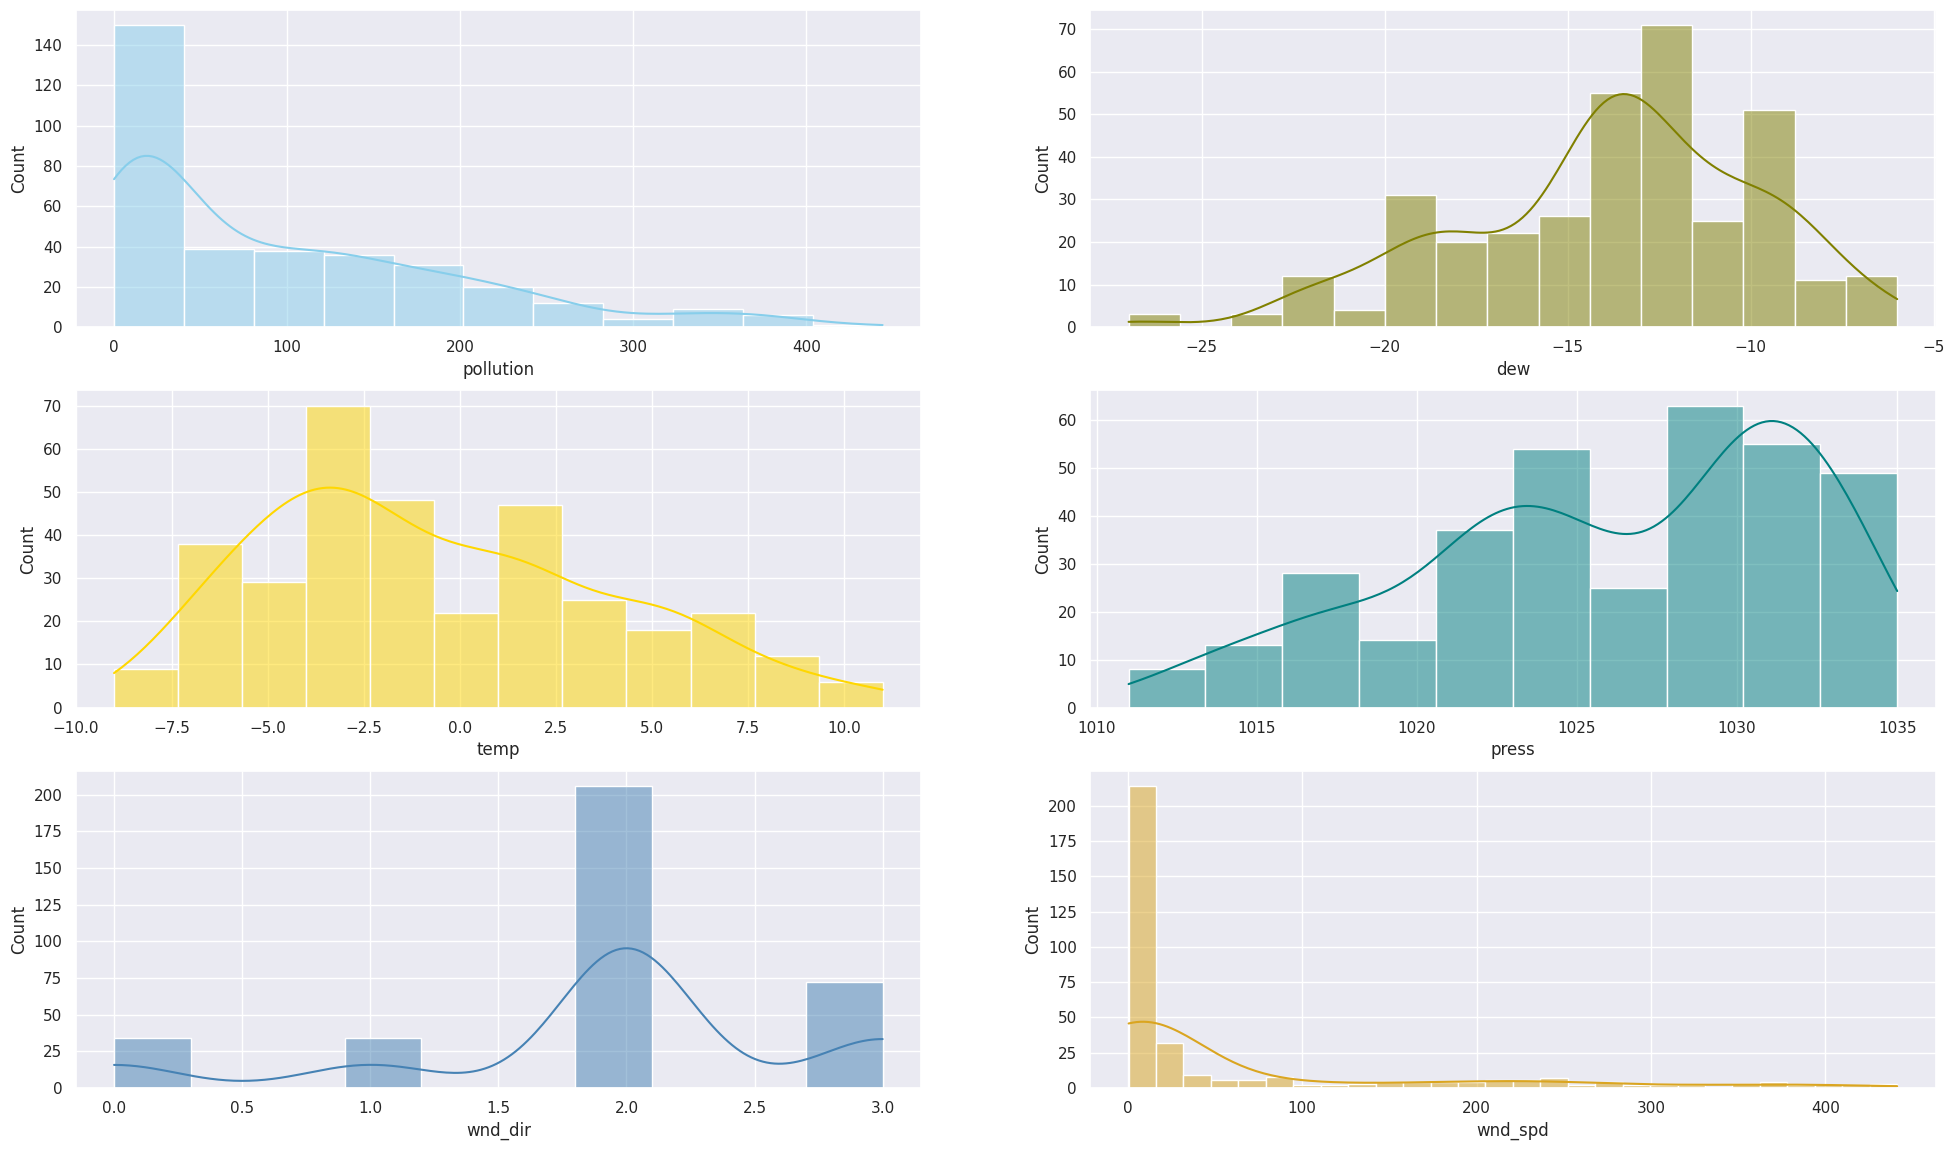

In [16]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(3,2, figsize=(24,14))

sns.histplot(data=df_test_scaled, x="pollution", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df_test_scaled, x="dew", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df_test_scaled, x="temp", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df_test_scaled, x="press", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df_test_scaled, x="wnd_dir", kde=True, color="steelblue", ax=axs[2, 0])
sns.histplot(data=df_test_scaled, x="wnd_spd", kde=True, color="goldenrod", ax=axs[2, 1])

plt.show()

In [17]:
scaler = MinMaxScaler()

# Define the columns to scale
columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir", 'wnd_spd',
       'snow', 'rain'])
    
df_test_scaled = df_test_scaled[columns]

# Scale the selected columns to the range 0-1
df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

# Show the scaled data
df_train_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [18]:
df_test_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,0.128773,0.352941,0.377049,0.654545,0.333333,0.005349,0.0,0.0
1,0.077465,0.338235,0.393443,0.654545,0.333333,0.012219,0.0,0.0
2,0.065392,0.352941,0.377049,0.654545,0.333333,0.015278,0.0,0.0
3,0.079477,0.352941,0.327869,0.672727,1.000000,0.000752,0.0,0.0
4,0.093561,0.382353,0.311475,0.672727,0.000000,0.002290,0.0,0.0


In [19]:
df_train_scaled = np.array(df_train_scaled)
df_test_scaled = np.array(df_test_scaled)

X = []
y = []
n_future = 1
n_past = 11

#  Train Sets
for i in range(n_past, len(df_train_scaled) - n_future+1):
    X.append(df_train_scaled[i - n_past:i, 1:df_train_scaled.shape[1]])
    y.append(df_train_scaled[i + n_future - 1:i + n_future, 0])
X_train, y_train = np.array(X), np.array(y)

#  Test Sets

X = []
y = []
for i in range(n_past, len(df_test_scaled) - n_future+1):
    X.append(df_test_scaled[i - n_past:i, 1:df_test_scaled.shape[1]])
    y.append(df_test_scaled[i + n_future - 1:i + n_future, 0])
X_test, y_test = np.array(X), np.array(y)

print('X_train shape : {}   y_train shape : {} \n'
      'X_test shape : {}      y_test shape : {} '.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train shape : (43789, 11, 7)   y_train shape : (43789, 1) 
X_test shape : (335, 11, 7)      y_test shape : (335, 1) 


### Creating a LSTM Model

In [22]:
# design network

model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(y_train.shape[1]))

# Compile the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

# Define callbacks for avoiding overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 11, 32)         │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,273 (32.32 KB)

 Trainable params: 8,273 (32.32 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# fit network
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

Epoch 1/200
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 2/200
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 3/200
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0068 - root_mean_squared_error: 0.0821 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 4/200
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 5/200
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1019
Epoch 6/200
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0063 - root_mean_squared_error: 0.0790 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 7/200
1232/1232 ━

### Evaluate the Model

In [24]:
  best_model = load_model('best_model.keras')

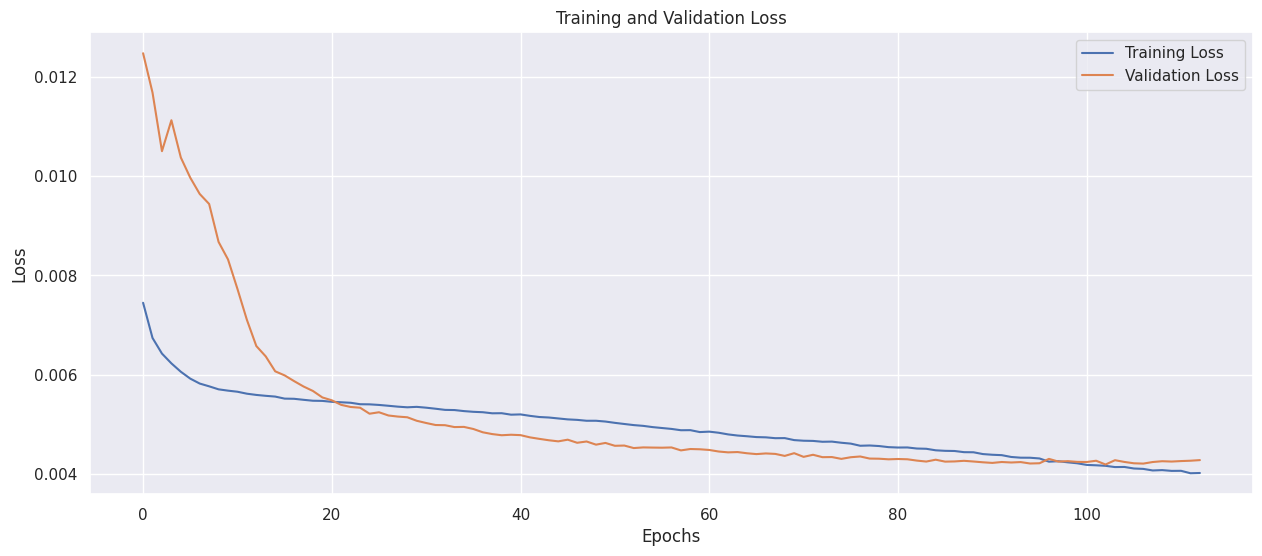

In [25]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
test_predictions = best_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
test_results.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


,Train Predictions,Actual
0,0.067852,0.171026
1,0.056883,0.160966
2,0.061084,0.146881
3,0.094805,0.125755
4,0.091102,0.130785


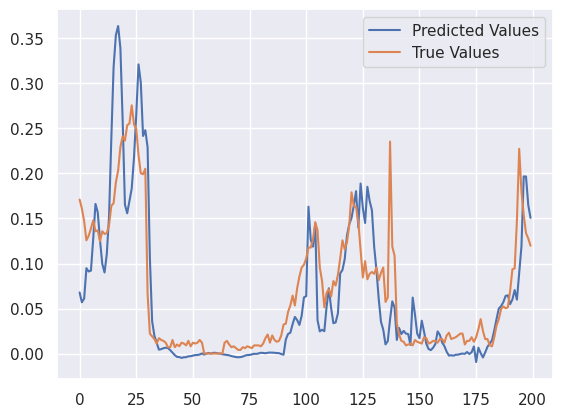

In [27]:
plt.plot(test_results['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results['Actual'][:200], label='True Values')
plt.legend()
plt.show()

In [30]:
rmse = sqrt(mse(y_test, test_predictions))
print('Test RMSE: %.5f',(rmse*100))

Test RMSE: %.5f 7.17650504137287


In [31]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test,test_predictions)
print(r2)

0.4781019739592527
